In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import shap
import pickle

In [7]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aidsin2026","key":"e008d7216fc8f15c1472e9b4e5baab5c"}'}

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Step 2: Downloading the Dataset from Kaggle
!pip install --upgrade kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --force

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 1.18GB/s]


In [10]:
# Extract the dataset
import zipfile
with zipfile.ZipFile('./brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./brain_tumor_data')


In [11]:
# Step 3: Data Loading and Preprocessing
def load_images(base_dir):
    images, labels = [], []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                label = os.path.basename(root)
                image = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (128, 128))
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_images('./brain_tumor_data')
X = X / 255.0  # Normalize images
X = X.reshape(-1, 128, 128, 1)

le = LabelEncoder()
y = le.fit_transform(y)

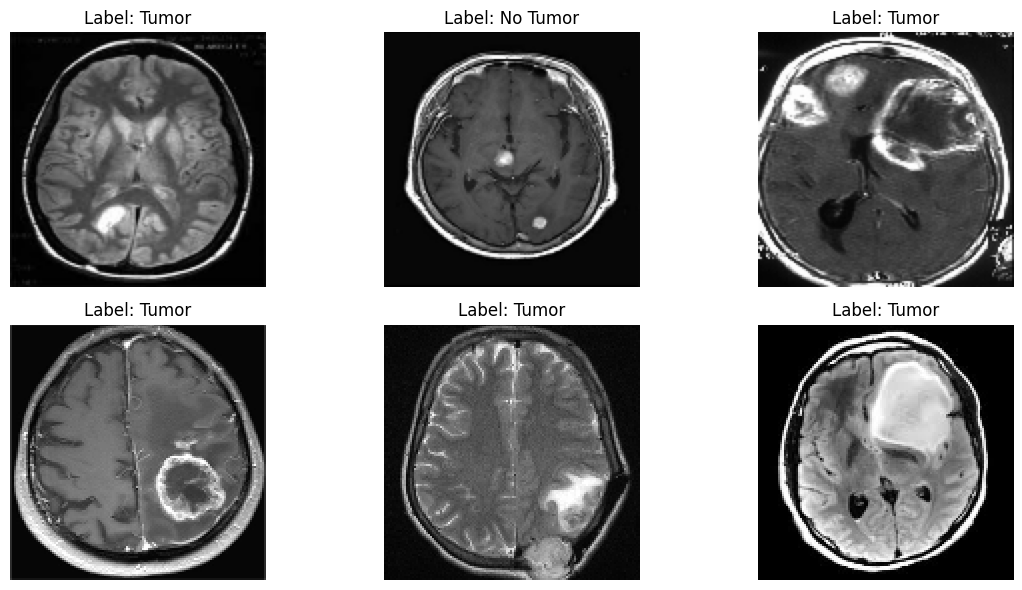

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display example images from the training set
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i].reshape(128, 128), cmap='gray')
    plt.title(f'Label: {"Tumor" if y_train[i] == 1 else "No Tumor"}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Step 4: Model Building (5 Models)
models = {}
accuracies = {}

In [14]:
# Model 1: CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=10, validation_split=0.2)
cnn_acc = model_cnn.evaluate(X_test, y_test)[1]
accuracies['CNN'] = cnn_acc
print(f'CNN Accuracy: {cnn_acc * 100:.2f}%')

# Save the CNN model
model_cnn.save("cnn_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5221 - loss: 1.1934 - val_accuracy: 0.7500 - val_loss: 0.5758
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7117 - loss: 0.5931 - val_accuracy: 0.7857 - val_loss: 0.4588
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7365 - loss: 0.5092 - val_accuracy: 0.8214 - val_loss: 0.3885
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7776 - loss: 0.4999 - val_accuracy: 0.8929 - val_loss: 0.3346
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8617 - loss: 0.3337 - val_accuracy: 0.8750 - val_loss: 0.2825
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8694 - loss: 0.3031 - val_accuracy: 0.9464 - val_loss: 0.2328
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9453 - loss: 0.1872 - val_accuracy: 0.9286 - val_loss: 0.2167
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9587 - loss: 0.1505 - val_accuracy: 0.9464 - val_loss: 0.1842
E

CNN Accuracy: 98.57%


In [15]:
# Model 2: SVM
from sklearn.svm import SVC
model_svm = SVC(kernel='linear')
model_svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)
svm_acc = accuracy_score(y_test, model_svm.predict(X_test.reshape(X_test.shape[0], -1)))
accuracies['SVM'] = svm_acc
print(f'SVM Accuracy: {svm_acc * 100:.2f}%')

# Save the SVM model
pickle.dump(model_svm, open("svm_model.pkl", "wb"))


SVM Accuracy: 97.14%


In [16]:
# Model 3: Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test.reshape(X_test.shape[0], -1)))
accuracies['Random Forest'] = rf_acc
print(f'Random Forest Accuracy: {rf_acc * 100:.2f}%')

# Save the Random Forest model
pickle.dump(model_rf, open("rf_model.pkl", "wb"))



Random Forest Accuracy: 100.00%


In [17]:
# Model 4: Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train.reshape(X_train.shape[0], -1), y_train)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test.reshape(X_test.shape[0], -1)))
accuracies['Logistic Regression'] = lr_acc
print(f'Logistic Regression Accuracy: {lr_acc * 100:.2f}%')

# Save the Logistic Regression model
pickle.dump(model_lr, open("lr_model.pkl", "wb"))



Logistic Regression Accuracy: 97.14%


In [18]:
# Model 5: KNN
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train.reshape(X_train.shape[0], -1), y_train)
knn_acc = accuracy_score(y_test, model_knn.predict(X_test.reshape(X_test.shape[0], -1)))
accuracies['KNN'] = knn_acc
print(f'KNN Accuracy: {knn_acc * 100:.2f}%')

# Save the KNN model
pickle.dump(model_knn, open("knn_model.pkl", "wb"))



KNN Accuracy: 74.29%


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 128, 128, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 128, 128, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src

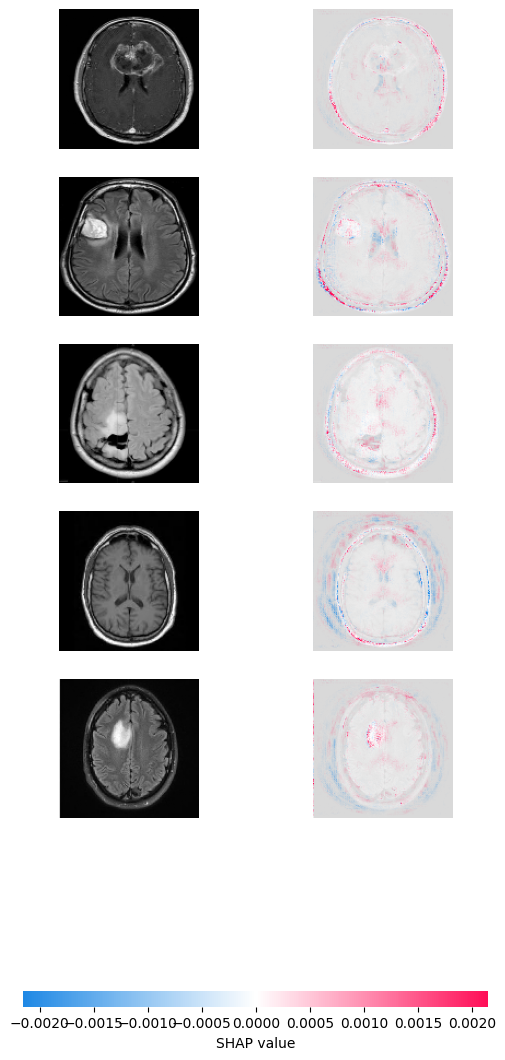

In [19]:
# Step 5: Explainable AI (SHAP)
explainer = shap.DeepExplainer(model_cnn, X_train[:100])  # Use a sample of training data
shap_values = explainer.shap_values(X_test[:5])
shap.image_plot(shap_values, X_test[:5])


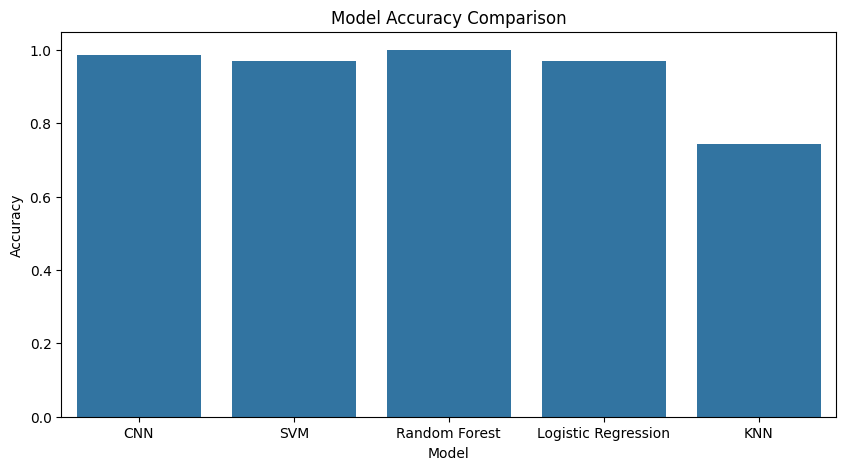

In [20]:
# Step 6: Accuracy Comparison Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


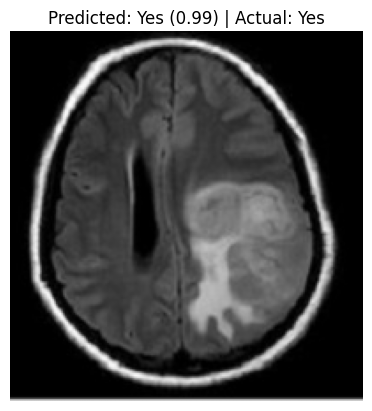

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


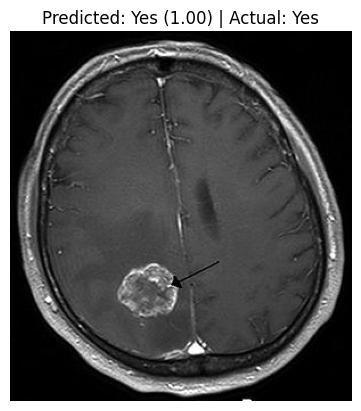

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


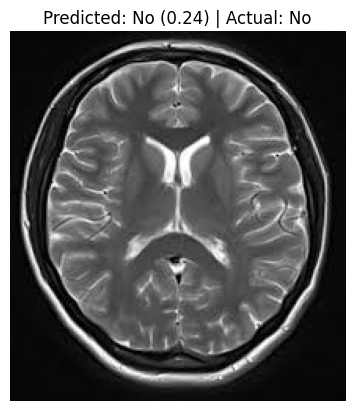

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


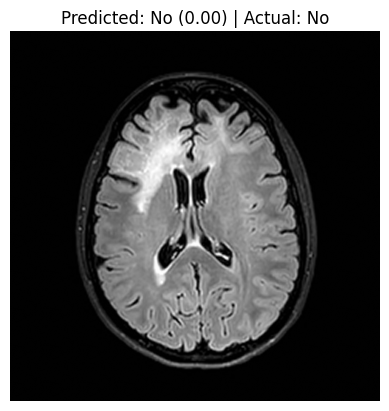

In [21]:
import numpy as np
import cv2
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained CNN model
model = tf.keras.models.load_model("cnn_model.h5")

# Function to preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    return image.reshape(1, 128, 128, 1)

# Load dataset to pick images
yes_images = [os.path.join(root, file) for root, _, files in os.walk('./brain_tumor_data/yes') for file in files if file.endswith(('.jpg', '.png'))]
no_images = [os.path.join(root, file) for root, _, files in os.walk('./brain_tumor_data/no') for file in files if file.endswith(('.jpg', '.png'))]

# Select 2 random images from each class
selected_images = random.sample(yes_images, 2) + random.sample(no_images, 2)

# Predict and display results
for img_path in selected_images:
    img = preprocess_image(img_path)
    prediction = model.predict(img)
    confidence = prediction[0][0]
    predicted_label = "Yes" if confidence > 0.5 else "No"
    actual_label = "Yes" if "yes" in img_path.lower() else "No"

    plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}) | Actual: {actual_label}")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


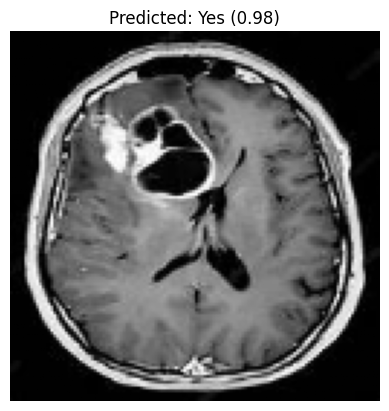

In [22]:
import requests
from io import BytesIO

# Function to predict from image URL
def predict_from_url(image_url):
    response = requests.get(image_url)
    image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128)) / 255.0
    image = image.reshape(1, 128, 128, 1)

    prediction = model.predict(image)
    confidence = prediction[0][0]
    predicted_label = "Yes" if confidence > 0.5 else "No"

    plt.imshow(image.reshape(128, 128), cmap='gray')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example usage:
predict_from_url("https://tse3.mm.bing.net/th?id=OIP.4oBsxJ5MTf3hXhJFFPQTcAHaIp&pid=Api&P=0&h=180")
